In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
%matplotlib inline

# This week we discussed how county officials are eyeing programs like mental health courts and co-responders as potential police reforms in Bucks County.
# You can read my story in the Bucks County Courier Times [here](https://bit.ly/2CdaAki) and in The Intelligencer [here](https://bit.ly/3abvzkd).
# I thought I'd take some time to look at 911 data in Bucks County to flesh out some details on mental health calls.

In [2]:
allcalls1=pd.read_csv("911_mental_health_court.csv")
allcalls1['datetime']=pd.to_datetime(allcalls1.datetime)
print(allcalls1.shape)
allcalls1.head(5)
allcalls1['datetime']=pd.to_datetime(allcalls1.datetime)

(4541087, 7)


# The data was collected through a series of Right to Know Law requests and consists of every police and EMS call to come through the 911 center in Bucks County. That's about 4.5 million calls beginning in January 2012 and ending April 10, 2020.
# For this analysis, I've removed address columns and kept just the incident type, town, date and time data needed.
# First, let's establish some baseline information.

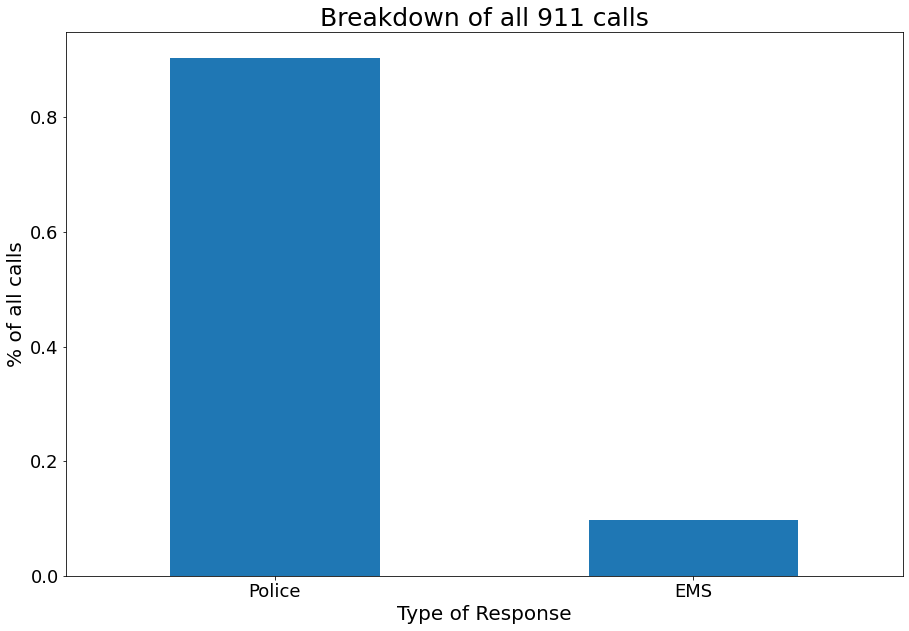

In [3]:
plt.figure(figsize=(15,10))
plt.ylabel("% of all calls",fontsize=20)
plt.xlabel('Type of Response',fontsize=20)
plt.title("Breakdown of all 911 calls",fontsize=25)
((allcalls1.ems_call.value_counts()/allcalls1.ems_call.count())).plot(kind="bar",fontsize=18,rot=0)
plt.savefig("twitter_charts/Call_pct_by_agency.jpg")

# The majority of all calls in the 911 database are police responses, while a little less than 10% are EMS calls. It's common for police to assist EMS calls, whether if they're asked to or if they are nearby and the call isn't at a location with adequate medical staff.

          total_time
ems_call            
EMS             36.0
Police         225.0


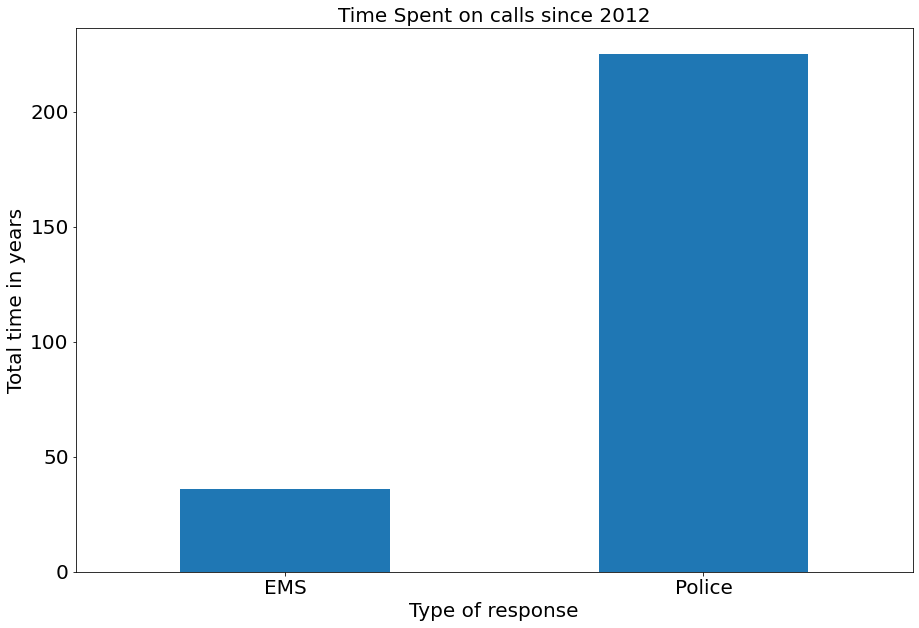

In [4]:
print((((allcalls1.groupby('ems_call').total_time.sum())/60/24/365).round()).to_frame())
(((allcalls1.groupby('ems_call').total_time.sum())/60/24/365).round()).to_frame().reset_index().plot(kind='bar',legend=False,
                                                                                                     title='Time spent on calls since 2012',
                                                                                                     x='ems_call',y='total_time',rot=0,
                                                                                                     figsize=(15,10),fontsize=20)
plt.title('Time Spent on calls since 2012',fontsize=20)
plt.ylabel('Total time in years',fontsize=20)
plt.box(True)
plt.xlabel("Type of response",fontsize=20)
plt.savefig("twitter_charts/Time_spent_by_agency.jpg")

# Police across Bucks County have collectively spent over 220 years worth of time logged through the 911 center. EMS crews have logged over 35 years of time since 2012.


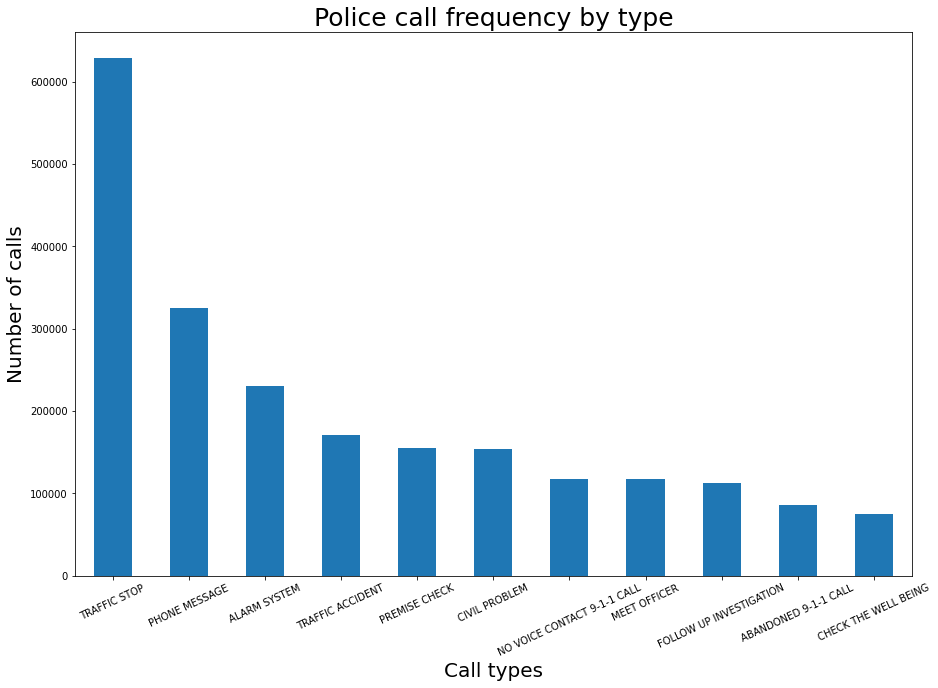

In [5]:
plt.figure(figsize=(15,10))
plt.ylabel("Number of calls",fontsize=20)
plt.xlabel('Call types',fontsize=20)
plt.title("Police call frequency by type",fontsize=25)
allcalls1[allcalls1.ems_call=='Police'].incident_type.value_counts().head(11).plot(kind='bar',figsize=(15,10),rot=25,fontsize=10)
plt.savefig("twitter_charts/Police_call_freq_by_type.jpg")

# Traffic stops, phone messages and alarm system calls account for the most common calls. Traffic stops alone account for about 14% of all police calls.

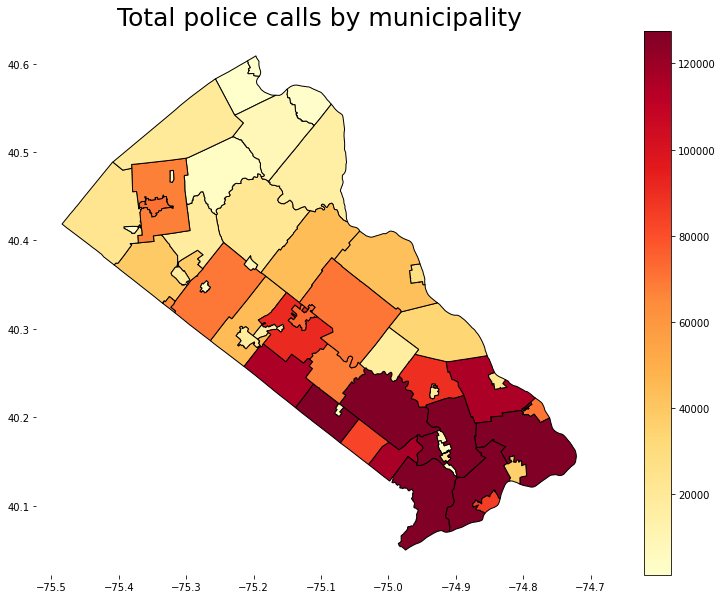

In [21]:
townmap=gpd.read_file("Pennsylvania Municipality Boundaries/geo_export_bbe8e428-3aed-43de-83b6-d15d670b715a.shp")
townmap=townmap[['county_nam','class_of_m','municipal1','geometry']]
townmap['class_of_m']=townmap.class_of_m.str.replace("1TWP|2TWP",'township').str.replace("BORO",'borough')
townmap['municipal1']=townmap.municipal1.str.lower()
townmap['towns']=townmap.municipal1+" "+townmap.class_of_m
townmap=townmap[townmap.county_nam=='BUCKS']
callsbytown=allcalls1[allcalls1.ems_call=='Police'].towns.value_counts().to_frame().rename(columns={'towns':'calls'}).reset_index().rename(columns={'index':'towns'})
callsbytown=pd.merge(townmap,callsbytown,on='towns')
callsbytown.plot(column='calls',cmap='YlOrRd',figsize=(15,10),edgecolor='black',legend=True,vmin=callsbytown.calls.min(),vmax=callsbytown.calls.mean()*2)
plt.title("Total police calls by municipality",fontsize=25)
plt.box(False)
plt.savefig("twitter_charts/police_callsMap.jpg")

# Police in lower and central Bucks County have seen the most calls, going well over 100,000 incidents logged for most of the regions. Some towns have logged fewer than 50,000 calls since 2012, but several upper Bucks communities also lack their own police forces and rely on state police and neighboring departments.

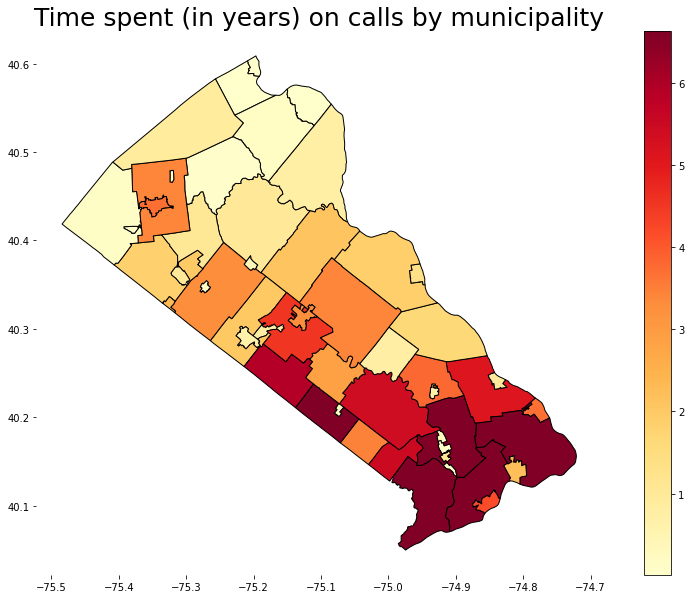

In [22]:
townmap=gpd.read_file("Pennsylvania Municipality Boundaries/geo_export_bbe8e428-3aed-43de-83b6-d15d670b715a.shp")
townmap=townmap[['county_nam','class_of_m','municipal1','geometry']]
townmap['class_of_m']=townmap.class_of_m.str.replace("1TWP|2TWP",'township').str.replace("BORO",'borough')
townmap['municipal1']=townmap.municipal1.str.lower()
townmap['towns']=townmap.municipal1+" "+townmap.class_of_m
townmap=townmap[townmap.county_nam=='BUCKS']
timebytown=(allcalls1[allcalls1.ems_call=='Police'].groupby('towns').total_time.sum()/60/24/365).to_frame().reset_index()
timebytown=pd.merge(townmap,timebytown,on='towns')
timebytown.plot(column='total_time',cmap='YlOrRd',figsize=(15,10),edgecolor='black',legend=True,vmin=timebytown.total_time.min(),vmax=timebytown.total_time.mean()*2)
plt.title("Time spent (in years) on calls by municipality",fontsize=25)
plt.box(False)
plt.savefig("twitter_charts/police_total_timeMap.jpg")

# As far as total time spent on calls, a handful of towns have logged over a decade in call time since 2012. Municipalities throughout the county have generally seen five or fewer years worth of police activity logged.
# I think we're about ready to move on to the specific calls now.
# I wrote a story on daily police activity through ride-alongs and with this 911 data last summer. That story can be found [here](http://bit.ly/36o3aVV).

In [8]:
Mental_health_calls=['MENTAL SUBJECT','SUICIDE ATTEMPT','PSYCHIATRIC EMERGENCY','CHECK THE WELL BEING']

2012     9285
2013     9381
2014     9847
2015    10783
2016    11464
2017    12257
2018    13527
2019    14065
2020     3619
Name: datetime, dtype: int64


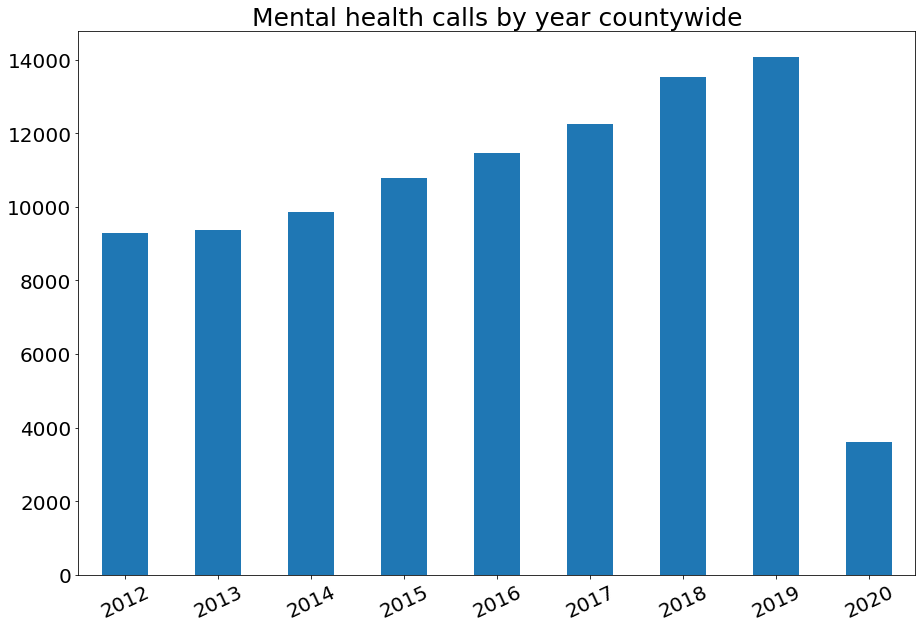

In [9]:
allcalls1[(allcalls1.ems_call=='Police')&(allcalls1.incident_type.isin(Mental_health_calls))].datetime.dt.year.value_counts().sort_index().plot(kind="bar",figsize=(15,10),fontsize=20,rot=25)
plt.title("Mental health calls by year countywide",fontsize=25)
plt.savefig("twitter_charts/mental_health_calls_by_year.jpg")
print(allcalls1[(allcalls1.ems_call=='Police')&(allcalls1.incident_type.isin(Mental_health_calls))].datetime.dt.year.value_counts().sort_index())

# We've assigned a handful of calls to a "Mental Health Call" variable and filtered the police calls for that incident type. We see here the total number of psychiatric emergency, suicide attempt, mental subject and well being checks have collectively increased to over 14,000 at the end of 2019.

2012    2021
2013    2125
2014    2282
2015    2356
2016    2507
2017    2722
2018    3010
2019    3098
2020    3226
Name: datetime, dtype: int64


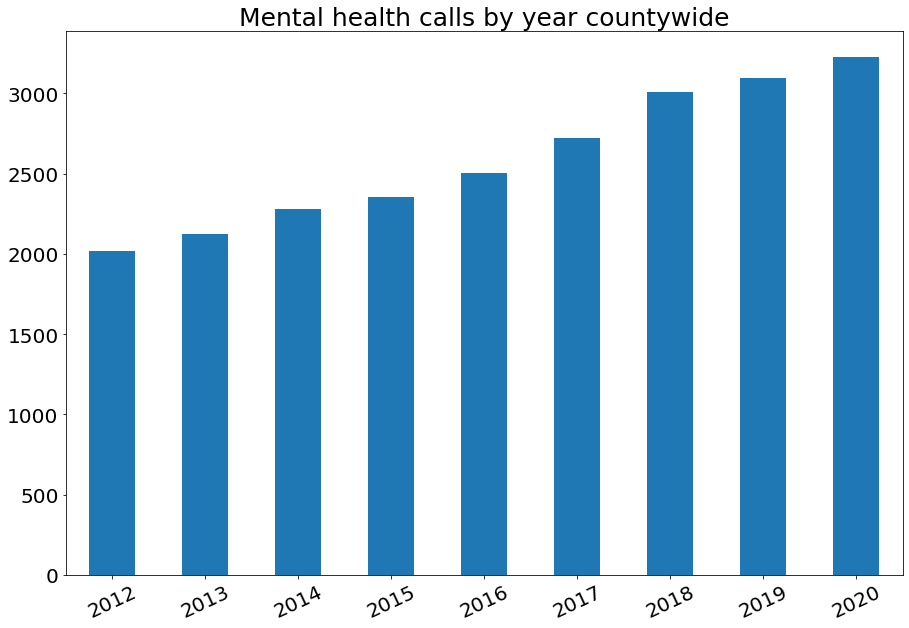

In [10]:
allcalls1[(allcalls1.ems_call=='Police')&(allcalls1.incident_type.isin(Mental_health_calls))&(allcalls1.datetime.dt.month<=3)].datetime.dt.year.value_counts().sort_index().plot(kind="bar",figsize=(15,10),fontsize=20,rot=25)
plt.title("Mental health calls by year countywide",fontsize=25)
plt.savefig("twitter_charts/mental_health_calls_first_quarter_by_year.jpg")
print(allcalls1[(allcalls1.ems_call=='Police')&(allcalls1.incident_type.isin(Mental_health_calls))&(allcalls1.datetime.dt.month<=3)].datetime.dt.year.value_counts().sort_index())

# Since we only have full monthly data up to March of 2020, I've compared only those months in the past several years. The upward trend continues, and 2020 would presumably see the most calls of any year if this continues.
# Marion Callahan and Christian Menno wrote an excellent story in 2017 about training efforts to better equip officers to handle mental health emergencies.
# You can read that full story [here](https://bit.ly/33LXfuT).
# We only had one year's worth of data at that point, but we estimated psychatric emergency calls alone accounted for just 0.2% of all police calls that year in Bucks County.


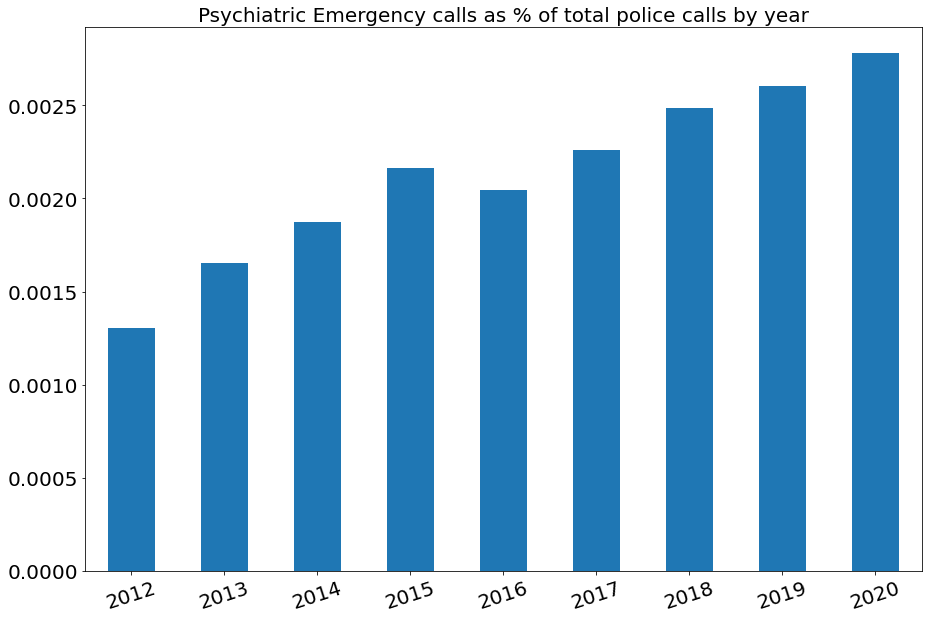

In [23]:
(allcalls1[(allcalls1.ems_call=='Police')&(allcalls1.incident_type.str.contains("PSYCHIATRIC EMERGENCY"))].datetime.dt.year.value_counts()/allcalls1[(allcalls1.ems_call=='Police')].datetime.dt.year.value_counts()).plot(kind='bar',figsize=(15,10),fontsize=20,rot=18)
plt.title("Psychiatric Emergency calls as % of total police calls by year",fontsize=20)
plt.savefig("twitter_charts/psychiatric_emergency_all_percent.jpg")

# That percentage hasn't changed too drastically since then, but it has increased to nearly 0.3%.
# Adjusted for the first three months of each year, we see the same trend, though slightly more erratic. 

Text(0.5, 1.0, 'Psychiatric Emergency calls as % of total police calls by year')

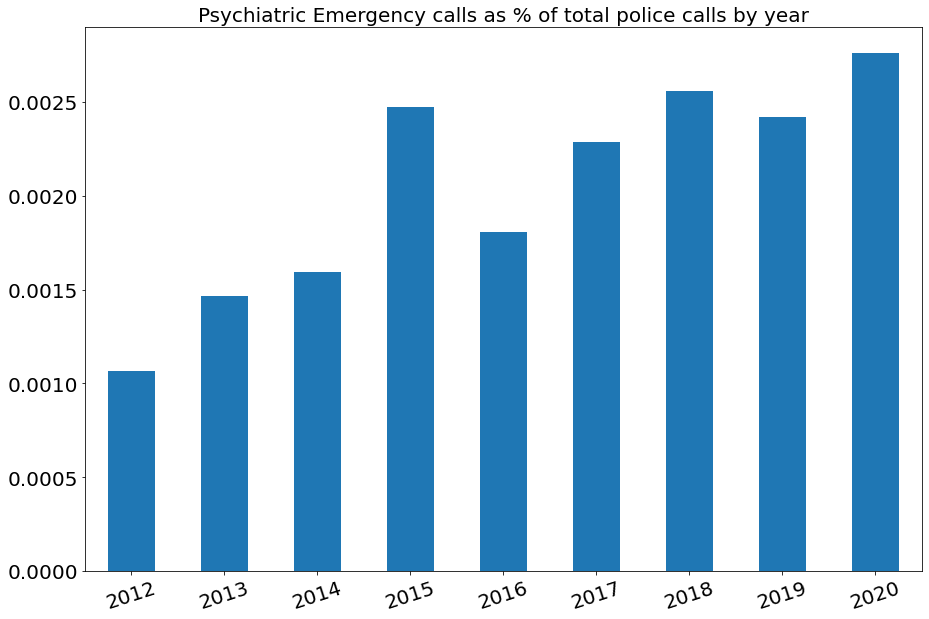

In [24]:
(allcalls1[(allcalls1.ems_call=='Police')&(allcalls1.incident_type.str.contains("PSYCHIATRIC EMERGENCY"))&(allcalls1.datetime.dt.month<=3)].datetime.dt.year.value_counts()/allcalls1[(allcalls1.ems_call=='Police')&(allcalls1.datetime.dt.month<=3)].datetime.dt.year.value_counts()).plot(kind='bar',figsize=(15,10),fontsize=20,rot=18)
plt.title("Psychiatric Emergency calls as % of total police calls by year",fontsize=20)

# Potential mental health calls in Bucks County aren't an area affecting one region of the county. Police departments across the county have seen over 125 calls by April 10, 2020. 
# If anything, mental health calls are growing in proportion to total calls from Quakertown to Bensalem. 

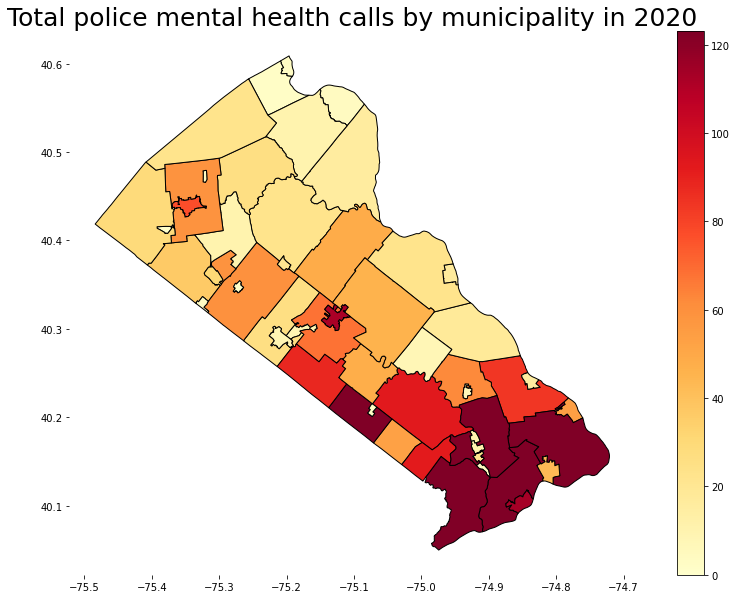

In [13]:
townmap=gpd.read_file("Pennsylvania Municipality Boundaries/geo_export_bbe8e428-3aed-43de-83b6-d15d670b715a.shp")
townmap=townmap[['county_nam','class_of_m','municipal1','geometry']]
townmap['class_of_m']=townmap.class_of_m.str.replace("1TWP|2TWP",'township').str.replace("BORO",'borough')
townmap['municipal1']=townmap.municipal1.str.lower()
townmap['towns']=townmap.municipal1+" "+townmap.class_of_m
townmap=townmap[townmap.county_nam=='BUCKS']
mental_healthcalls=allcalls1[(allcalls1.ems_call=='Police')&(allcalls1.incident_type.isin(Mental_health_calls))&(allcalls1.datetime.dt.year==2020)].towns.value_counts().to_frame().rename(columns={'towns':'calls'}).reset_index().rename(columns={'index':'towns'})
mental_healthcalls=pd.merge(townmap,mental_healthcalls,on='towns')
mental_healthcalls.plot(column='calls',cmap='YlOrRd',figsize=(15,10),edgecolor='black',legend=True,vmin=0,vmax=mental_healthcalls.calls.mean()*2)
plt.title("Total police mental health calls by municipality in 2020",fontsize=25)
plt.box(False)
plt.savefig("twitter_charts/police_mental_health_calls_2020_Map.jpg")

# To paraphrase Bucks County District Attorney Matt Weintraub, police departments have become a kind of catch-all service for many towns.
# That's essentially why he's looking into a co-responder program. Police could turn over the scene of a mental health call to a kind of social worker once the scene is secured.
# When there's a serious criminal offense involving a person with mental illness, a mental health court program like the one proposed by County Commissioner Chairwoman Diane Ellis Marseglia would be useful.


# The data isn't perfect, and this is in no way meant to be a comprehensive or definitive look at mental health issues in daily police activity. 
# As I always like to say, "Sometimes a cardiac arrest is an overdose, and an overdose is sometimes a cardiac arrest."
# That's also why I didn't review overdose calls in this particular analysis. An overdose call could certainly fall into the co-responder duties, and the county already has a drug court set up. 
# I also didn't get into police staffing today. That's literally a story for another day. Hopefully Sunday.